In [1]:
from collections import defaultdict
import json
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import os
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import pickle
from sklearn import metrics

In [2]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

# init metadata

In [6]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3N'\n($f_{1}$)", "L3N'\n($f_{2}$)", "L3N\n($f_{1}$)", "L3N\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3N'($f_{1}$)", "L3N'($f_{2}$)", "L3N($f_{1}$)", "L3N($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# parse predicted PPIs & GOSemSim scores

In [4]:
# parse ppi of different predictor & ds into one data structure
methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']

topPPIs = {}
for randSz in range(50, 100, 10):
    topPPIs[randSz] = defaultdict(dict)
    for method in methods:
        for ds in ds_names:
            if randSz == 50:
                filename = "./linkPred_out_reduced/{}_{}_topPPI.json".format(method, ds)
            else:
                filename = "./linkPred_out_reduced/{}_{}_randSz{}_topPPI.json".format(method, ds, randSz)
            with open(filename, "r") as f:
                tmpPPIs = json.loads(f.read())
                topPPIs[randSz][method][ds] = []
                for trial in range(len(tmpPPIs)):
                    topPPIs[randSz][method][ds].append(["\t".join(i) for i in tmpPPIs[trial]])
            
# structure: topPPIs = {'commonNeighbor': ['bioGRID': [[ppi1, ppi2], ...], ...], ...}
print(topPPIs[70]['commonNeighbor']['bioGRID_human'][0][0:10])

['MYC\tPLEKHA4', 'NR2C2\tPLEKHA4', 'NR2C2\tPLEKHA4', 'EFTUD2\tPLEKHA4', 'KIAA1429\tTRIM25', 'KIAA1429\tTRIM25', 'NR2C2\tMYC', 'MYC\tNR2C2', 'NR2C2\tMYC', 'MYC\tNR2C2']


In [5]:
GO_PPIMap, GO_scoreMap = [], []

fNames = set()
for file in os.listdir("./GOSemSim_out"): fNames.add(file.split(" _")[0])
    
for file in fNames:
    if not ('human' in file or 'HuRI' in file): continue
    with open("./GOSemSim_out/{} _PPI.json".format(file), "r") as f:
        readPPIs = json.loads(f.read())
        GO_PPIMap += readPPIs
    with open("./GOSemSim_out/{} _GOSemSim.json".format(file), "r") as f:
        readScores = json.loads(f.read())
        GO_scoreMap += readScores
        
GOSemSimMap = {}
for i in range(len(GO_PPIMap)):
    if GO_PPIMap[i][0] is None or GO_PPIMap[i][1] is None: continue
    GOSemSimMap["\t".join(GO_PPIMap[i])] = GO_scoreMap[i]
        
print(list(GOSemSimMap.keys())[0:10])
print(list(GOSemSimMap.values())[0:10])
print(list(GOSemSimMap.values()).count(None), len(list(GOSemSimMap.values())))

['CYSRT1\tHOXA1', 'CYSRT1\tKRTAP5-9', 'KRTAP10-8\tKRTAP5-9', 'KRTAP10-8\tCREB5', 'CYSRT1\tKRTAP4-2', 'CYSRT1\tADAMTSL4', 'CYSRT1\tLCE5A', 'CYSRT1\tCATSPER1', 'CYSRT1\tLCE3D', 'LCE2B\tKRTAP10-8']
[0.604, 1, 1, 0.571, 1, 0.709, 1, 0.713, 1, 0.893]
9204397 25421487


# Get GOSemSim scores of PPIs into df

In [6]:
# construct df for plotting
df_dict = defaultdict(list)
ds_names = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']

for randSz in range(50, 100, 10):
    for method in methods:
        for ds in ds_names:
            for trial in range(len(topPPIs[randSz][method][ds])):
                for i in range(len(topPPIs[randSz][method][ds][trial])):
                    topPPI = topPPIs[randSz][method][ds][trial][i]
                    df_dict['randSz'].append(randSz)
                    df_dict['ds'].append(ds)
                    df_dict['trial'].append(trial)
                    df_dict['rank'].append(i)
                    if topPPI in GOSemSimMap: df_dict["score"].append(GOSemSimMap[topPPI])
                    else: df_dict["score"].append(np.nan)
                    df_dict["predictor"].append(methods_names[method])

df = pd.DataFrame(df_dict)
df

,randSz,ds,trial,rank,score,predictor
0,50,bioGRID_human,0,0,0.149,CN
1,50,bioGRID_human,0,1,0.170,CN
2,50,bioGRID_human,0,2,0.170,CN
3,50,bioGRID_human,0,3,0.170,CN
4,50,bioGRID_human,0,4,NaN,CN
...,...,...,...,...,...,...
100168875,90,HuRI,9,5107,0.487,rand
100168876,90,HuRI,9,5108,NaN,rand
100168877,90,HuRI,9,5109,NaN,rand
100168878,90,HuRI,9,5110,NaN,rand


# Get data for plotting

In [7]:
# get top 10% score group by method & ds, avg across trial, ignore NaN

topTenPPIs = df.copy()
topTenPPIs.drop(columns=['rank'], inplace=True)
topTenPPIs

,randSz,ds,trial,score,predictor
0,50,bioGRID_human,0,0.149,CN
1,50,bioGRID_human,0,0.170,CN
2,50,bioGRID_human,0,0.170,CN
3,50,bioGRID_human,0,0.170,CN
4,50,bioGRID_human,0,NaN,CN
...,...,...,...,...,...
100168875,90,HuRI,9,0.487,rand
100168876,90,HuRI,9,NaN,rand
100168877,90,HuRI,9,NaN,rand
100168878,90,HuRI,9,NaN,rand


In [8]:
# create dict of sorted mean GOSemSim scores & conf interval
meanScore_dict, std_dict, score_dict = {}, {}, {}
for randSz in range(50, 100, 10):
    meanScore_dict[randSz], std_dict[randSz], score_dict[randSz] = defaultdict(dict), defaultdict(dict), defaultdict(dict)
    for ds in set(topTenPPIs['ds']):
        # get mean GOSemSim & conf Int for each predictor
        for predictor in set(topTenPPIs[(topTenPPIs['ds'] == ds) & (topTenPPIs['randSz'] == randSz)]['predictor']):
            tmpMean = []
            for trial in range(10):
                curScores = np.asarray(topTenPPIs[(topTenPPIs['randSz'] == randSz) & (topTenPPIs['ds'] == ds) & (topTenPPIs['predictor'] == predictor) & (topTenPPIs['trial'] == trial)]['score'])
                curScores = curScores[~np.isnan(curScores)]
                tmpMean.append(np.mean(curScores))
            score_dict[randSz][ds][predictor] = tmpMean
            meanScore_dict[randSz][ds][predictor] = np.mean(tmpMean)
            std_dict[randSz][ds][predictor] = np.std(tmpMean)
        meanScore_dict[randSz][ds] = dict(sorted(meanScore_dict[randSz][ds].items(), key=lambda item: item[1])[::-1])

        tmp = {}
        for predictor in meanScore_dict[randSz][ds]: tmp[predictor] = std_dict[randSz][ds][predictor]
        std_dict[randSz][ds] = tmp
    
print(meanScore_dict)
print("")
print(std_dict)

with open("./GOSemSim_out/score_dict_human.pkl", "wb") as f:
    pickle.dump(score_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./GOSemSim_out/meanScore_dict_human.pkl", "wb") as f:
    pickle.dump(meanScore_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./GOSemSim_out/std_dict_human.pkl", "wb") as f:
    pickle.dump(std_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

{50: defaultdict(<class 'dict'>, {'bioGRID_human': {'CRA': 0.6258513019591035, 'CN': 0.6147387989227537, 'L3E1_f2': 0.608186467300721, 'L3E1_f1': 0.6028967743162517, 'L3': 0.5973418098293032, 'CH2': 0.5891564479976708, 'Sim': 0.570040235978768, 'rand': 0.5591924717335326}, 'MINT_human': {'CN': 0.6435459400252233, 'CRA': 0.6163237268775907, 'rand': 0.5979752404211559, 'L3E1_f1': 0.5835879831446347, 'L3E1_f2': 0.5783905552507081, 'L3': 0.5663260760363704, 'CH2': 0.5574740740345888, 'Sim': 0.5340664315179223}, 'HuRI': {'CH2': 0.8048758774947185, 'CN': 0.8039439385513086, 'L3': 0.8028426171302281, 'L3E1_f1': 0.8002391771059356, 'L3E1_f2': 0.795230064248198, 'Sim': 0.7947726780687352, 'CRA': 0.7854042071521157, 'rand': 0.6997841754144422}, 'STRING_human': {'CN': 0.6892091598449431, 'CH2': 0.6757003446390633, 'L3E1_f2': 0.6673634867989392, 'L3': 0.6670087450118815, 'CRA': 0.6637453250290124, 'Sim': 0.6625153548626963, 'L3E1_f1': 0.6602027620487092, 'rand': 0.5286086747631759}}), 60: defaultd

In [4]:
meanScore_dict, std_dict, score_dict = {}, {}, {}
with open("./GOSemSim_out/score_dict_human.pkl", "rb") as f:
    score_dict = pickle.load(f)
with open("./GOSemSim_out/meanScore_dict_human.pkl", "rb") as f:
    meanScore_dict = pickle.load(f)
with open("./GOSemSim_out/std_dict_human.pkl", "rb") as f:
    std_dict = pickle.load(f)

# Create figure

In [8]:
# AUC of scatter plot
auc_map = {}

dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
for ds in dss:
    auc_map[ds] = defaultdict(list)
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        for trial in range(10):
            X = [randSz/100 for randSz in range(50, 100, 10)]
            Y = [score_dict[randSz][ds][method][trial] for randSz in range(50, 100, 10)]
            auc_map[ds][method].append(metrics.auc(X, Y))
            
sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'bioGRID_human': {'rand': 0.2218861590254846, 'Sim': 0.22946251015703162, 'L3': 0.23490298270589208, 'CH2': 0.23519644032105594, 'L3E1_f1': 0.2407029051849467, 'L3E1_f2': 0.24310716392637172, 'CN': 0.2482183267556095, 'CRA': 0.2518762058249358}, 'STRING_human': {'rand': 0.21121019291797505, 'Sim': 0.2675246521854112, 'L3E1_f2': 0.26805878502826136, 'L3E1_f1': 0.26862192675032304, 'CRA': 0.2705929162177353, 'L3': 0.2730882615149211, 'CH2': 0.27489813621658454, 'CN': 0.27918234502489836}, 'MINT_human': {'Sim': 0.206105583905103, 'CH2': 0.22246066393732583, 'L3': 0.227288989262611, 'L3E1_f2': 0.22877616980165866, 'L3E1_f1': 0.23296246611352617, 'rand': 0.2381712464345644, 'CN': 0.2597615177052422, 'CRA': 0.2666939570393292}, 'HuRI': {'rand': 0.2790394270878197, 'Sim': 0.3194658556835702, 'L3E1_f2': 0.3229866000461464, 'L3': 0.3231298742955334, 'L3E1_f1': 0.3235365522251835, 'CH2': 0.3238424031072784, 'CRA': 0.32509627330562596, 'CN': 0.3270458664724549}}


# gridspec

bioGRID_human
STRING_human
MINT_human
HuRI


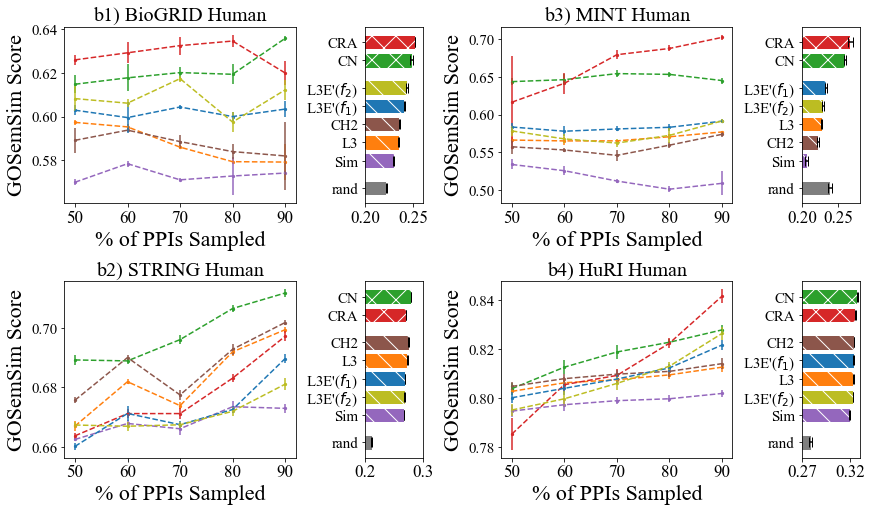

In [8]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7))
widths = [4,1,4,1]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[1, 0])
            , fig.add_subplot(spec[0, 2]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[1, 1])
           , fig.add_subplot(spec[0, 3]), fig.add_subplot(spec[1, 3])]


# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    , fmt='--', color=colors[method]
                    , yerr=np.transpose(np.asarray(
                        [std_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 100, 10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                   , s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Sampled")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_xticks([randSz for randSz in range(50, 100, 10)])
    ax.set_ylabel("GOSemSim Score")
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

# barAxes
xlims = [[0.2, 0.26], [0.2, 0.3], [0.2, 0.28], [0.27, 0.33]]
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    
    pos = [0,1.5,2.5,3.5,4.5,5.5,7,8]
    xtick = [k for k in list(sorted_mean_auc[ds].keys()) if k not in ['rand', 'CRA', 'CN']]
    xtick = ['rand'] + xtick + [k for k in list(sorted_mean_auc[ds].keys()) if k in ['CRA', 'CN']]
    
    #xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.barh(pos, [sorted_mean_auc[ds][x] for x in xtick]
                      , xerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                       , tick_label=[labels[x] for x in xtick]
                      , edgecolor='white', capsize=5)
    for j, patch in enumerate(ax.patches): patch.set_hatch(hatches[j])
    ax.set_xlim(xlims[i])
    if i != 1: ax.set_xticks([xlims[i][0], xlims[i][0]+0.05])
    else: ax.set_xticks([xlims[i][0], xlims[i][0]+0.1])
    
plt.savefig("./img_experiments/GOSemSimComplete_human.png", dpi=300)
plt.show()

bioGRID_human
STRING_human
MINT_human
HuRI


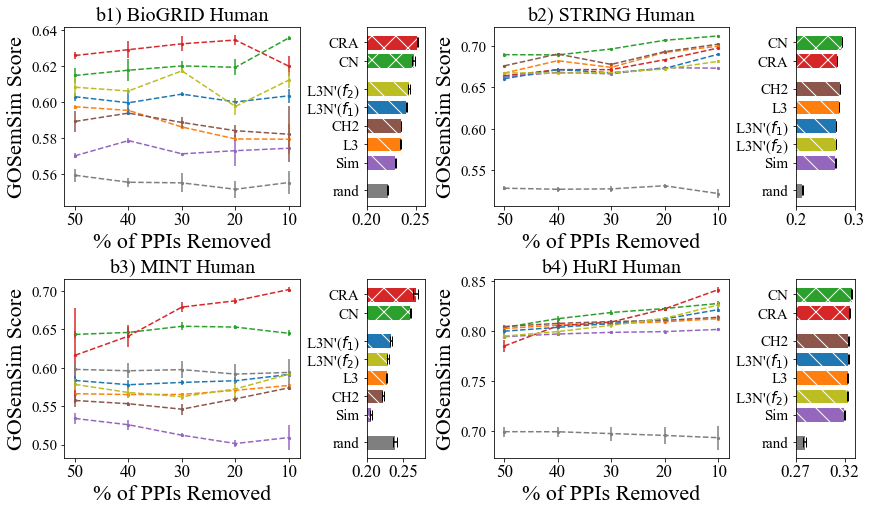

In [9]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7))
widths = [4,1,4,1]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 2])
            , fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[0, 3])
           , fig.add_subplot(spec[1, 1]), fig.add_subplot(spec[1, 3])]


# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
        ax.errorbar([randSz for randSz in range(50, 0, -10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    , fmt='--', color=colors[method]
                    , yerr=np.transpose(np.asarray(
                        [std_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 0, -10)]
                    , [meanScore_dict[randSz][ds][method] for randSz in range(50, 100, 10)]
                   , s=5, color=colors[method])
        ax.set_xlabel("% of PPIs Removed")
    #ax.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
    ax.set_xticks([randSz for randSz in range(50, 0, -10)])
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_ylabel("GOSemSim Score")
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

# barAxes
xlims = [[0.2, 0.26], [0.2, 0.3], [0.2, 0.28], [0.27, 0.33]]
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    
    pos = [0,1.5,2.5,3.5,4.5,5.5,7,8]
    xtick = [k for k in list(sorted_mean_auc[ds].keys()) if k not in ['rand', 'CRA', 'CN']]
    xtick = ['rand'] + xtick + [k for k in list(sorted_mean_auc[ds].keys()) if k in ['CRA', 'CN']]
    
    #xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.barh(pos, [sorted_mean_auc[ds][x] for x in xtick]
                      , xerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                       , tick_label=[labels[x] for x in xtick]
                      , edgecolor='white', capsize=5)
    for j, patch in enumerate(ax.patches): patch.set_hatch(hatches[j])
    ax.set_xlim(xlims[i])
    if i != 1: ax.set_xticks([xlims[i][0], xlims[i][0]+0.05])
    else: ax.set_xticks([xlims[i][0], xlims[i][0]+0.1])
    
plt.savefig("./img_experiments/GOSemSimComplete_wRand_human.png", dpi=300)
plt.show()

# p-val

In [10]:
# p val
# sample to do: top 2 both to third, between top 2
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
pairs = [
    [['L3E1_f1', 'L3E1_f2']]
    , [['L3E1_f1', 'L3E1_f2']]
    , [['L3', 'CH2'], ['L3E1_f1', 'rand']]
    , [['L3E1_f1', 'CH2']]
]
for i in range(len(dss)):
    ds = dss[i]
    for pair in pairs[i]:
        pop1 = auc_map[ds][pair[0]]
        pop2 = auc_map[ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{}: {} {}: {}".format(ds, pair[0], pair[1], pVal))

bioGRID_human: L3E1_f1 L3E1_f2: 1.0129383570465726e-06
STRING_human: L3E1_f1 L3E1_f2: 0.00024842058042032184
MINT_human: L3 CH2: 9.913791795924306e-09
MINT_human: L3E1_f1 rand: 4.791768868667057e-05
HuRI: L3E1_f1 CH2: 0.15938934762146173
